# Coupled local functions

In this example, our goal is to construct an approximation for the function $$u(x) = \sin{(2 \pi x)} \cos{(5 \pi x)} - x(x-0.5)(x-0.75)$$
using a coupled local function in the domain $\Omega = [0,1]$.

Begin by importing the required modules to run the Python code.

In [117]:
# linear algegbra package for python
import numpy as np

# import cycle to help with plot colors
from itertools import cycle

# import plotting packages and set default figure options
useserif = False # use a serif font with figures?
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
if useserif:
    plt.rcParams["font.family"] = "serif"
    plt.rcParams['text.usetex'] = True
else:
    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams['text.usetex'] = False
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

# import the coupled local function library
import CoupledLocalFunctions as clf

## Choosing the support points

We approximate $u$ using $n$ support points $\{x_i\}_{i=1}^{n}$ such that $x_i \in \Omega$. For this example, we choose equally space pointed in $[0,1]$.

In [118]:
index1 = 5 
# the number of support points will be 2(2i+1)
nSupportPoints = 2*(2*index1+1)
index2 = nSupportPoints-index1-1
# the indices index1 and index2 correspond to example support points

supportPointLocations = np.linspace(0.0, 1.0, num=nSupportPoints)

In the next block, we plot the true function and the support points, highlighting two support points (red dots). We demonstrate how to define and use local functions using these support points.

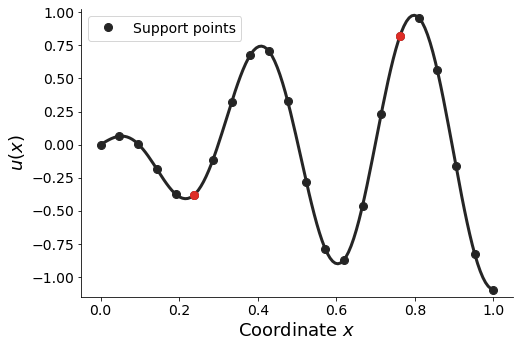

In [119]:
def TrueSolution(x):
    return np.sin(2.0*x)*np.cos(5.0*np.pi*x) - x*(x-0.25)*(x-0.75)

# use a function to plot the exact solution so that the "true" evaluations stay local variables
def PlotTrueSolution():
    # choose points where we are going to evaluate the function (for plotting)
    pnts = np.linspace(0.0, 1.0, num=150)
    u = [TrueSolution(x) for x in pnts]
    
    # evaluate the true solution at each support point
    usupp = [TrueSolution(x) for x in supportPointLocations]
    
    # plot the exact evaluation
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(pnts, u, color='#252525', linewidth=3)
    ax.plot(supportPointLocations, usupp, 'o', color='#252525', label='Support points', markersize=8)
    ax.plot(supportPointLocations[index1], usupp[index1], 'o', color='#de2d26', markersize=8)
    ax.plot(supportPointLocations[index2], usupp[index2], 'o', color='#de2d26', markersize=8)
    ax.legend(loc='best')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([1.05*min(u), 1.05*max(u)])
    ax.set_xlabel(r'Coordinate $x$')
    ax.set_ylabel(r'$u(x)$')
    plt.show()
    
PlotTrueSolution()

## Define the local functions

Associate a function $\ell_i: \Omega \mapsto \mathbb{R}$ with each support point $x_i$.

Let $\mathcal{F}_i$ be a $q_i$ dimensional function space such that $\ell_i \in \mathcal{F}_i$. We may choose a different function space for each support point. Let $\{\phi_i^{(r)}: \Omega \mapsto \mathbb{R}\}_{r=0}^{q_i-1}$ be basis functions of $\mathcal{F}_i$ and define the vector $\phi_i(x) = [\phi_i^{(0)}(x),\, \phi_i^{(1)}(x),\, ...,\, \phi_i^{(q_i-1)}(x)]^{\top}$. The local function is defined by coefficients $p_i \in \mathbb{R}^{q_i}$ such that $$\ell_i(x) = p_i \cdot \phi_i(x).$$

We will use the $k_i \geq q_i$ nearest neighbors to $x_i$ to learn the coefficients $p_i$. Notationally, let $I(x, j)$ be the index of the $j^{th}$ nearest support point to $x$. We use the convention that $I(x_i, 0) = i$ and, therefore, $I(x, 0)$ is the index of the closest support point to $x$. We also use the shorthand $I(i,j) = I(x_i, j)$. Define the radius $$\delta_{i,k_i} = \vert x_i-x_{I(i,k_i)} \vert.$$ We want the local function to be most accurate in the radius $\delta_{i,k_i}$ ball centered at $x_i$.

### Basis function examples

We first define two example basis functions that span (i) a polynomial space and (ii) a sine/cosine space. We first define a local transformation $$\hat{x}(x) = \frac{x-x_i}{\delta_{i,k_i}}.$$ We define the basis functions in the local coordinate system $\phi(x) = \hat{\phi}(\hat{x}(x))$. Typically, we choose basis functions that orthogonal in the unit ball.

#### Polynomial basis

Let the basis function $\hat{\phi}_i^{(r)}$ define a $r^{th}$ order polynomial. For example, the monomial basis functions are: $\hat{\phi}_i^{(0)}(\hat{x}) = 1$, $\hat{\phi}_i^{(1)}(\hat{x}) = \hat{x}$, $...$, $\hat{\phi}_i^{(q_i-1)}(\hat{x}) = \hat{x}^{q_i-1}$. Typically, we use orthogonal polynomials such as:

- Legendre
- Jacobi
- Laguerre
- Probabilist Hermite
- Physicist Hermite

For the remainder of this example, we assume Legendre polynomials.

Begin by creating a $p^{th}$ order polynomial basis. In this one dimensional example, this is a total order basis of degree $p$. We now plot each basis function for $p=4$ in the transformed (local) coordinate system.


There are 9 basis functions in the polynomial basis.


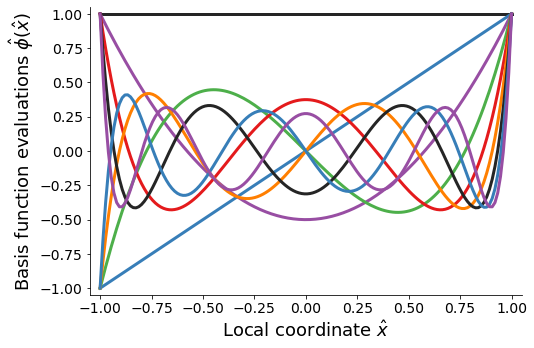

In [120]:
def PlotPolynomialBasis():
    # create the basis 
    polynomialBasisOptions = dict()
    polynomialBasisOptions["InputDimension"] = 1
    polynomialBasisOptions["Order"] = 8
    polynomialBasis = clf.PolynomialBasis.TotalOrderBasis(polynomialBasisOptions)

    print('There are', polynomialBasis.NumBasisFunctions(), 'basis functions in the polynomial basis.')

    # choose points where we are going to evaluate the basis functions (for plotting)
    pnts = np.linspace(-1.0, 1.0, num=150)
    
    basisEvals = [None]*len(pnts)
    for i in range(len(pnts)):
        basisEvals[i] = polynomialBasis.EvaluateBasisFunctions([pnts[i]])
    basisEvals = np.array(basisEvals).T
    
    # plot the exact evaluation
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    colors = ['#252525', '#377eb8', '#984ea3', '#4daf4a', '#e41a1c', '#ff7f00']
    for evals, c in zip(basisEvals, cycle(colors)):
        ax.plot(pnts, evals, color=c, linewidth=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim([-1.05, 1.05])
    ax.set_ylim([-1.05, 1.05])
    ax.set_xlabel(r'Local coordinate $\hat{x}$')
    ax.set_ylabel(r'Basis function evaluations $\hat{\phi}(\hat{x})$')
    plt.show()
    
PlotPolynomialBasis()

### Sine/cosine basis

Let the sine/cosine basis be $\hat{\phi}_i^{(0)}(\hat{x}) = 1$, $\hat{\phi}_i^{(2 j-1)}(\hat{x}) = \sin{(\pi j \hat{x})}$, and $\hat{\phi}_i^{(2 j)}(\hat{x}) = \cos{(\pi j \hat{x})}$ for $j>0$.

There are 9 basis functions in the sine/cosine basis.


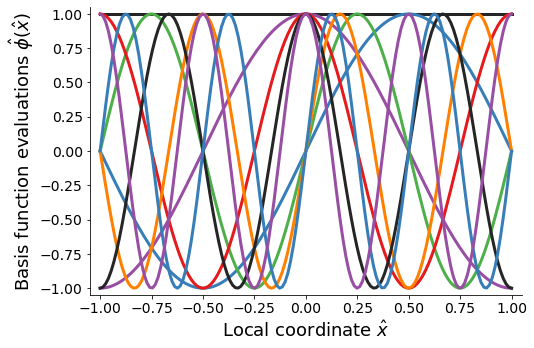

In [121]:
def PlotSinCosBasis():
    # create the basis 
    sincosBasisOptions = dict()
    sincosBasisOptions["InputDimension"] = 1
    sincosBasisOptions["Order"] = 4
    sincosBasis = clf.SinCosBasis.TotalOrderBasis(sincosBasisOptions)

    print('There are', sincosBasis.NumBasisFunctions(), 'basis functions in the sine/cosine basis.') 
    
    # choose points where we are going to evaluate the basis functions (for plotting)
    pnts = np.linspace(-1.0, 1.0, num=150)
    
    basisEvals = [None]*len(pnts)
    for i in range(len(pnts)):
        basisEvals[i] = sincosBasis.EvaluateBasisFunctions([pnts[i]])
    basisEvals = np.array(basisEvals).T
    
    # plot the exact evaluation
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    colors = ['#252525', '#377eb8', '#984ea3', '#4daf4a', '#e41a1c', '#ff7f00']
    for evals, c in zip(basisEvals, cycle(colors)):
        ax.plot(pnts, evals, color=c, linewidth=3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim([-1.05, 1.05])
    ax.set_ylim([-1.05, 1.05])
    ax.set_xlabel(r'Local coordinate $\hat{x}$')
    ax.set_ylabel(r'Basis function evaluations $\hat{\phi}(\hat{x})$')
    plt.show()
    
PlotSinCosBasis()

## Uncoupled local functions

Let's first consider the "uncoupled" case, where the local functions associated with each support are independent.

For each point, we find the $k_i \geq q_i$ nearest neighbors. Recall that $I(i, j)$ is the $j^{th}$ nearest neighbor to $x_i$, using the convention $I(i, 0) = i$. Define the Vandermonde matrix ($V_i \in \mathbb{R}^{(k_i+1) \times q_i}$) for the $i^{th}$ support point such that row $j$ is the basis function associated with support point $x_i$ evaluated at its neighbor $x_{I(i,j)}$
$$
V_i = \left[ \begin{array}{c}
(\phi_i(x_{I(i,0)}))^{\top} \\
(\phi_i(x_{I(i,1)}))^{\top} \\
\vdots \\
(\phi_i(x_{I(i,k_i)}))^{\top} 
\end{array} \right].
$$
Given coefficients $p_i \in \mathbb{R}^{q_i}$, the $j^{th}$ component of the vector $V_i p_i$ is the local function $\ell_i$ evaluated at the $j^{th}$ nearest neighbor. Let 
$$
\bar{u}_i = \left[ \begin{array}{c}
u(x_{I(i,0)}) \\
u(x_{I(i,1)}) \\
\vdots \\
u(x_{I(i,k_i)})
\end{array} \right]
$$
be the $k_i+1$ dimensional vector of exact function evaluations at the neighboring support points. The optimal coefficients for the <em>uncoupled</em> local function are 
$$
p_i = \min_{p \in \mathbb{R}^{q_i}}{D_{i}(p)} = \frac{1}{2} \| V_i p - \bar{u}_i \|_{K_i}^2,
$$
where $\|x\|_A = x^{\top} A x$ and $K_i \in \mathbb{R}^{k_i \times k_i}$ is the diagonal kernel matrix whose $j^{th}$ diagonal value is $K_i^{(j)} = k_i((x_i-x_{I(i,j)})^2/\delta_{i,k_i}^2)$. Here, $K_i: \mathbb{R} \mapsto \mathbb{R}^{+}$ is a compactly supported kernel function such that $k_i(0) = 1$ and $k_i(\delta) = 0$ for $\delta>1$. In this example, we assume the hat kernel 
$$
k_i(\delta) = \begin{cases}
1 & \mbox{if } 0 \leq \delta \leq 1 \\
0 & \mbox{else.}
\end{cases}
$$
We compute the solution to this optimization problem by solving
$$
V_i^{\top} K_i V_i p_i = V_i^{\top} K_i \bar{u}_i.
$$

### Create the "model"

Another way to think about this minimization problem is that we are minimizing the difference between the local function $\ell^{(i)}$ and the "true" function $u$
$$
p_i = \min_{p \in \mathbb{R}^{q_i}}{D_{i}(p)} = \frac{1}{2} \sum_{j=1}^{k} (\ell_i(x_{I(i,j)}) - u(x_{I(i,j)}))^2 k_i((x_i - x_{I(i,j)})^2),
$$
which is weighted by the kernel function $k_i$

#### Aside: looking forward to a model-based implementation

Suppose we expect $u$ to satisfy the equation $\mathcal{L}(u) = f$ at the support point $x_i$. In this case, we minimize 
$$
p_i = \min_{p \in \mathbb{R}^{q_i}}{D_{i}(p)} = \frac{1}{2} \sum_{j=1}^{k} (\mathcal{L}(\ell_i(x_{I(i,j)})) - f(x_{I(i,j)}))^2 k_i((x_i - x_{I(i,j)})^2).
$$
Setting $\mathcal{L}$ equal to the identity and $f=u$ recovers the data-based implementation. For now, we assume this case but note this generalization.

We implement this by creating a <tt>Model</tt> associated with each support point. In this example, we use the default implementation that $\mathcal{L}$ is the identity. We, therefore, need to implement the right hand side $f=u$.

In [122]:
class Observations(clf.Model):
    def __init__(self, options):
        clf.Model.__init__(self, options)
        
    def RightHandSideComponentImpl(self, x, outind):
        assert(len(x)==1) # only one input dimension 
        assert(outind==0) # only one output dimension
        return TrueSolution(x[0])

### Create the support points

Recall, we have $n$ support points $\{x_i\}_{i=1}^{n}$ and we need to associate a local function with each of them. Let's first create support point objects and give each its own basis functions, which defines the local function space $\mathcal{F}_i$. In this example, we could use either a polynomial basis or sin/cos basis. Although, in priciple we could also use a different basis type for each support point.

We also make the "local" transformation $\hat{x}(x) = (x-x_i)/\delta_{i,k_i}$ optional. If the "LocalBasis" option is <tt>False</tt> then we just set $\phi(x) = \hat{\phi}(x)$. We find using the local basis transformation works well for the polynomial basis, but not the sin/cos basis.

In [123]:
# each support point will create its own basis function based on the options passed to it 

# polynomial basis 
polyBasisOptions = dict()
polyBasisOptions["Type"] = "TotalOrderPolynomials"
polyBasisOptions["Order"] = 4

# sine/cosine basis
sincosBasisOptions = dict()
sincosBasisOptions["Type"] = "TotalOrderSinCos"
sincosBasisOptions["Order"] = 2
sincosBasisOptions["LocalBasis"] = False

# create the model for this support point
modelOptions = dict()
modelOptions["InputDimension"] = 1
modelOptions["OutputDimension"] = 1
model = Observations(modelOptions)

usePolyBasis = True

# create the support points
supportPoints = [None]*len(supportPointLocations)
for i in range(len(supportPointLocations)):
    # the support point options 
    supportPointOptions = dict()
    supportPointOptions["BasisFunctions"] = "Basis"
    if usePolyBasis:
        supportPointOptions["Basis"] = polyBasisOptions
    else:
        supportPointOptions["Basis"] = sincosBasisOptions
    
    supportPoints[i] = clf.SupportPoint([supportPointLocations[i]], model, supportPointOptions)

### Compute the optimal coefficients 

Computing the optimal coefficients for each support point is a two step process: (i) create a "cloud" of support points that computes each point's nearest neighbors and (ii) use the nearest neighbors to minimize the cost function.

Both of these steps are done in the constructor for the <tt>SupportPointCloud</tt> and the <tt>LocalFunction</tt>.

This block also plots the surrogate model. We split the plotted result into colored regions, each of which correspond to a different support point. The surrogate evalautes the local function associated with the closest support point. For two of the support points we plot the associated local function over a larger. We can see that they the local function is accurate in a region around the support point, but the error increases as we move farther away.

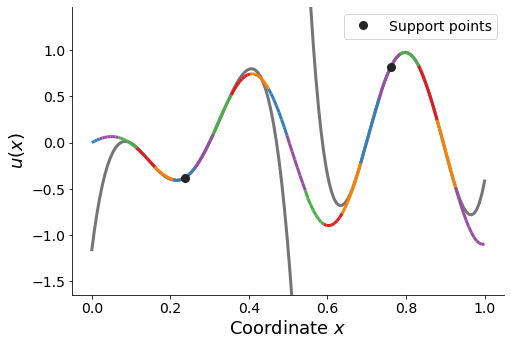

In [125]:
# create the support point cloud---the constructor computes the nearest neighbors
cloudOptions = dict()
cloud = clf.SupportPointCloud(supportPoints, cloudOptions)

# compute the optimal coefficients for each support point
funcOptions = dict()
func = clf.LocalFunction(cloud, funcOptions)

# use a function to plot the exact solution so that the "true" evaluations stay local variables
def PlotSolution():
    # choose points where we are going to evaluate the function (for plotting)
    pnts = np.linspace(0.0, 1.0, num=150)
    
    # evaluate the true solution 
    u = [TrueSolution(x) for x in pnts]
    
    uestimated = [func.Evaluate([x]) [0] for x in pnts]
    points = np.array([pnts, uestimated]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # determine the closest support point and evaluate the surrogate model 
    closestSupport = [func.NearestNeighborIndex([x]) for x in pnts]
    
    # evaluate the true solution at each support point
    usupp = [TrueSolution(x) for x in supportPointLocations]
    
    # evaluate the example support ponits
    suppPoint1Evals = [supportPoints[index1].EvaluateLocalFunction([x]) for x in pnts]
    suppPoint2Evals = [supportPoints[index2].EvaluateLocalFunction([x]) for x in pnts]
    
    # plot the exact evaluation
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    #ax.plot(pnts, u, color='#252525', linewidth=3)
    ax.plot(pnts, suppPoint1Evals, color='#757575', linewidth=3, zorder=0)
    ax.plot(pnts, suppPoint2Evals, color='#757575', linewidth=3, zorder=0)
    colors = cycle(['#377eb8', '#984ea3', '#4daf4a', '#e41a1c', '#ff7f00'])
    cols = [None]*len(supportPoints)
    for i, c in zip(range(len(supportPoints)), colors):
        cols[i] = c
    cmap = ListedColormap(cols)
    norm = BoundaryNorm(range(len(supportPoints)), cmap.N)
    lc = LineCollection(segments, cmap=cmap, norm=norm, zorder=1)
    lc.set_array(np.array(closestSupport[1:]))
    lc.set_linewidth(3)
    line = ax.add_collection(lc)
    ax.plot(supportPointLocations[index1], usupp[index1], 'o', color='#252525', label='Support points', markersize=8)
    ax.plot(supportPointLocations[index2], usupp[index2], 'o', color='#252525', markersize=8)
    ax.legend(loc='best')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([1.5*min(u), 1.5*max(u)])
    ax.set_xlabel(r'Coordinate $x$')
    ax.set_ylabel(r'$u(x)$')
    plt.show()
    
PlotSolution()